<a href="https://colab.research.google.com/github/dimaakapout/HSE_homeworks/blob/master/DL/priginal%22HW3_tinyImageNet_Kovalenkov_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#plt.imshow(x1[0].cpu().numpy().transpose(1,2,0))

In [ ]:
ОТЧЕТ 

1. арх 2конв + свертка + линейный 600-200 дали около 20%

In [ ]:
def training_step(batch, model, device=torch.device('cpu')):
    data, target = batch
    
    # закидываем данные и модель на один и тот же device
    data, target = data.to(device), target.to(device)
    model.to(device)
    
    # включаем train mode (обязательно например при наличии dropout, batch_norm и т.д.)
    model.train()
    
    logits = model(data)
    loss = F.cross_entropy(logits, target)
    
    # loss.item() эквивалентно loss.detach().cpu().numpy()
    logs = {'train_ce_loss': loss.item()}
    
    return {'loss': loss, 'log': logs}

def train_one_epoch(model, loader, optimizer, scheduler=None, device=torch.device('cpu')):
    logs = []
    for batch in tqdm(loader):
        output = training_step(batch, model, device)
        loss = output['loss']
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None:
            scheduler.step()
        logs.append(output['log'])
    return logs

def train_epoch_end(logs):
    avg_train_ce_loss = np.mean([x['train_ce_loss'] for x in logs])
    return {'avg_train_ce_loss': avg_train_ce_loss}

def validation_step(batch, model, device=torch.device('cpu')):
    data, target = batch
    
    # закидываем данные и модель на один и тот же device
    data, target = data.to(device), target.to(device)
    model.to(device)
    
    # включаем eval mode (обязательно например при наличии dropout, batch_norm и т.д.)
    model.eval()
    
    start_time = time.perf_counter()
    with torch.no_grad():
        logits = model(data)
    inference_time_per_batch = time.perf_counter() - start_time
    
    pred = logits.argmax(dim=1, keepdim=True)
    
    correct = pred.eq(target.view_as(pred)).sum().item()
    log = {'correct': correct, 'inference_time_per_batch': inference_time_per_batch, 'amount': pred.shape[0]}
    return {'log': log}

def val_one_epoch(model, loader, device=torch.device('cpu')):
    logs = []
    for batch in tqdm(loader):
        output = validation_step(batch, model, device)
        logs.append(output['log'])
    return logs
        
def validation_epoch_end(logs):
    total_amount = np.sum([x['amount'] for x in logs])
    total_correct = np.sum([x['correct'] for x in logs])
    accuracy = 100 * total_correct / total_amount 
    avg_inference_time_per_batch = np.mean([x['inference_time_per_batch'] for x in logs])
    return {'val_accuracy (%)': accuracy, 'avg_inference_time_per_batch (sec)': avg_inference_time_per_batch}
    
def configure_optimizers(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scheduler = None
    return optimizer, scheduler

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer, scheduler = configure_optimizers(model)
num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch}:")
    train_logs = train_one_epoch(model, train_loader, optimizer, scheduler, device)
    print(train_epoch_end(train_logs))
    val_logs = val_one_epoch(model, val_loader, device)
    print(validation_epoch_end(val_logs))

In [ ]:
print("Test stage:")
val_logs = val_one_epoch(model, val_loader)
print(validation_epoch_end(val_logs))

In [ ]:
val_accuracy = comput_val_acc(...)
print("Validation accuracy: %.2f%%" % (val_accuracy * 100))

NameError: ignored

In [ ]:
# Параметры модели



# Homework 3

Домашние задания являются полностью опциональными, оценки никуда не идут.

### Дедлайн: 21.06.20 (вс) 21:00 мск

### Формат сдачи

__Вариант 1__: этот ipynb файл с кодом

дополнительно добавьте:
* "checkpoint" файл из `torch.save(model.state_dict(), ...)` который содержит веса модели для задачи 1, 3 и поможет удостовериться в точности на валидации
* имеется возможность перезапустить весь ipynb файл, чтобы убедиться в финальном результате, например в 1й и 3й задаче (можете сделать конструкцию if else, н: если файл с весами присутствует, тогда показываем точность, иначе запускаем training рутину и выводим в конце точность)

__Вариант 2__:
сдаёте в виде набора .py скриптов (н. train.py, test.py, ...) на каждое задание с инструкцией как запустить и убедиться в полученных вами результатах

# Задача 1 - Train your own model (6 баллов)

В этом задании вы построете сверточную нейросеть (CNN) для решения Tiny ImageNet классификации. Постарайтесь добиться максимальной точности на валидации.

### Оценивание

* За преодоление каждого порога даётся 1 балл
  * 25.0%
  * 30.0%
  * 32.5%
  * 35.0%
  * 37.5%
  * 40.0%
    
### Ограничения

* __Нельзя использовать предобученные нейросети.__ Сами архитектуры использовать можно.

### Советы

* Одно изменение в один момент времени
* Используйте GPU, постарайтесь написать device-agnostic код, чтобы нигде не присутствовало `.cuda()`, а было `.to(device)`
* Логируйте промежуточный результаты, например в TensorBoard
* С чем можно поиграться: optimizer, lr scheduler, архитектура, инициализации, loss, регуляризации (dropout, cutmix, weight decay, аугментации и тд), и кучу всего разного
* Про "фишечки", которые можно внедрить для улучшения качества, можно посмотреть здесь https://arxiv.org/abs/1812.01187
* Постарайтесь по максимуму переиспользовать написанный код, то есть реализовать в виде набора функций например тренировочную рутину и ее использовать в задаче 1, 2, 4
* Как обычно: читабельный, понятный код приветствуется

### Какую архитектуру выбрать для обучения?
* пишем сами
* берём готовую архитектуру (например отсюда https://github.com/rwightman/pytorch-image-models (очень классный ресурс с модными архитектурами) или отсюда https://pytorch.org/docs/stable/torchvision/models.html)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # размер изображений по умолчанию

In [ ]:
#import tiny_imagenet
#tiny_imagenet.download(".")

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip # Stanford 200 imagenet

Тренировочные и валидационные данные лежат в `tiny-imagenet-200/train` и `tiny-imagenet-200/val`.

In [ ]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import time
from tqdm import tqdm
import os
from urllib.request import urlretrieve


In [ ]:
# Разархивация архива
if not os.path.exists("tiny-imagenet-200"):
    import zipfile
    with zipfile.ZipFile("tiny-imagenet-200.zip", 'r') as archive:
        archive.extractall("tiny-imagenet-200")

In [ ]:
# Разархивация архива
if not os.path.exists("tiny-imagenet-200"):
    import zipfile
    with zipfile.ZipFile("tiny-imagenet-200.zip", 'r') as archive:
        archive.extractall("tiny-imagenet-200")


dataset_root = "tiny-imagenet-200/tiny-imagenet-200"

train_dataset = torchvision.datasets.ImageFolder(
    os.path.join(dataset_root, "train"),
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2768, 0.2689, 0.2819])
    ]))
test_dataset = torchvision.datasets.ImageFolder(
    os.path.join(dataset_root, "test"),
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2768, 0.2689, 0.2819])
    ]))

batch_size = 64

loaderGGGTrain = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True, 
    drop_last=True,
    num_workers=1)

iterator = iter(loaderGGGTrain)
X, Y = iterator.next()

loaderGGGTest = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True, 
    drop_last=True,
    num_workers=1)

In [ ]:
batch_size = 500

total_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False, # False чтобы не перемешать классы
    drop_last=True,
    num_workers=1)

total_iter = iter(total_loader)

# В цикле переберем все классы и создадим массив по 100 примеров каждого класса
for i in tqdm(range(10)): # Первые 10 классов
  n_images = 200
  images, labels = total_iter.next()
  x = images.numpy()
  y = labels.numpy()
  if i == 0:
    dataTrainX = x[:n_images]
    dataTrainY = y[:n_images]
    dataTestX = x[n_images:n_images+100]
    dataTestY = y[n_images:n_images+100]             
    continue
  dataTrainX = np.vstack((dataTrainX, x[:n_images]))
  dataTrainY = np.hstack((dataTrainY, y[:n_images]))
  dataTestX = np.vstack((dataTestX, x[n_images:n_images+100]))
  dataTestY = np.hstack((dataTestY, y[n_images:n_images+100]))


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


In [ ]:
dataTestX.shape, dataTrainX.shape, dataTrainY.shape, dataTestY.shape

((1000, 3, 64, 64), (2000, 3, 64, 64), (2000,), (1000,))

In [ ]:
# Свой датасет
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, xdata, ydata):

        self.target = ydata
        self.images = xdata

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()


        image = self.images[idx]
        target = self.target[idx]
        sample = [image, target]
        
        return sample

In [ ]:
trainData = CustomDataset(dataTrainX, dataTrainY)
testData = CustomDataset(dataTestX, dataTestY)

In [ ]:
batch_size = 50

train_loader = torch.utils.data.DataLoader(
    trainData,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=1)

test_loader = torch.utils.data.DataLoader(
    testData,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=1)

train_iter = iter(train_loader)
test_iter = iter(test_loader)

In [ ]:
x_train, y_train = train_iter.next()
x_test, y_test = test_iter.next()

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([50, 3, 64, 64]),
 torch.Size([50, 3, 64, 64]),
 torch.Size([50]),
 torch.Size([50]))

In [ ]:
# dataset_root = "tiny-imagenet-200/tiny-imagenet-200"

# train_dataset = torchvision.datasets.ImageFolder(
#     os.path.join(dataset_root, "train"),
#     transform=transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2768, 0.2689, 0.2819])
#     ]))

# val_dataset = torchvision.datasets.ImageFolder(
#     os.path.join(dataset_root, "val"),
#     transform=transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2768, 0.2689, 0.2819])
#     ]))

# batch_size = 30
# train_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=batch_size,
#     shuffle=True,
#     drop_last=True,
#     num_workers=1)
# val_loader = torch.utils.data.DataLoader(
#     val_dataset,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=1)

In [ ]:
# train_iter = iter(train_loader)
# images, labels = train_iter.next()

In [ ]:
# plt.imshow(images[0].numpy().transpose(1,2,0))

In [ ]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
# grid = torchvision.utils.make_grid(images, pad_value=2)

# plt.imshow(grid.numpy().transpose((1, 2, 0)))
# plt.axis('off')
# plt.title(labels.numpy());

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, (3,3), stride=2)
    self.conv2 = nn.Conv2d(6, 12, (3,3), stride=1)
    self.maxpool1 = nn.MaxPool2d((3,3))

    self.conv3 = nn.Conv2d(12, 24, (3,3), stride=1)
    self.conv4 = nn.Conv2d(24, 48, (3,3), stride=1)
    self.conv5 = nn.Conv2d(48, 96, (3,3), stride=1)

    self.fc1 = nn.Linear(864, 200) # НЕ ЗАБЫВАТЬ МЕНЯТЬ ЧИСЛО КЛАССОВ
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.maxpool1(x)

    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))

    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    return x

In [ ]:
class Model2(nn.Module):
  def __init__(self):
    super(Model2, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, (3,3), stride=2)
    self.bn1 = nn.BatchNorm2d(6)
    self.conv2 = nn.Conv2d(6, 12, (3,3), stride=1)
    self.bn2 = nn.BatchNorm2d(12)
    self.maxpool1 = nn.MaxPool2d((3,3))

    self.conv3 = nn.Conv2d(12, 24, (3,3), stride=1)
    self.bn3 = nn.BatchNorm2d(24)
    self.conv4 = nn.Conv2d(24, 48, (3,3), stride=1)
    self.bn4 = nn.BatchNorm2d(48)
    self.conv5 = nn.Conv2d(48, 96, (3,3), stride=1)
    self.bn5 = nn.BatchNorm2d(96)
    self.fc1 = nn.Linear(864, 200) 
  
  def forward(self, x):
    x = self.bn1(self.conv1(x))
    x = F.relu(x)
    x = self.bn2(self.conv2(x))
    x = F.relu(x)    
    x = self.maxpool1(x)

    x = self.bn3(self.conv3(x))
    x = F.relu(x)    
    x = self.bn4(self.conv4(x))
    x = F.relu(x)
    x = self.bn5(self.conv5(x))
    x = F.relu(x)

    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    return x

In [ ]:
# model = Model()
# model.forward(x_train).shape

In [ ]:
model = Model2()
model(X).shape

torch.Size([64, 200])

In [ ]:
model = Model()
criterion = F.cross_entropy
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Обучение и валидация

def training_step(batch, model, device=torch.device('cpu')):
  data, target = batch
  data = data.to(device)
  target = target.to(device)
  model.to(device)

  model.train(mode=True)

  output = model(data)
  loss = F.cross_entropy(output, target)

  return loss

def train_one_epoch(model, loader, optimizer, device=torch.device('cpu')):
  logs = np.array([])
  for batch in tqdm(loader):
    loss_batch = training_step(batch, model, device)
    optimizer.zero_grad()
    loss_batch.backward()
    optimizer.step()
    logs = np.append(logs, loss_batch.item())
    
  return logs.mean()

def validation_step(batch, model, device=torch.device('cpu')):
    
    # закидываем данные и модель на один и тот же device
    data, target = batch
    data = data.to(device)
    target = target.to(device)
    model.to(device)
    
    # включаем eval mode (обязательно например при наличии dropout, batch_norm и т.д.)
    model.train(mode=False)
    
    with torch.no_grad():
      output = model(data)
    #output = model(data)
    loss = F.cross_entropy(output, target)

    return loss

def val_one_epoch(model, loader, device=torch.device('cpu')):
    logs = np.array([])
    for batch in tqdm(loader):
        val_loss = validation_step(batch, model, device)
        logs = np.append(logs, val_loss.item())
    return logs.mean()


In [ ]:
# top N accuracy

def topN_epoch(model, loader, device, n):
    logs = np.array([])
    for batch in tqdm(loader):
        acc = topN_step(batch, model, device, n)
        logs = np.append(logs, acc)
    return logs.mean()

def topN_step(batch, model, device, n):
    
    data, target = batch
    data = data.to(device)
    target = target.to(device)
    model.to(device)
    
    model.train(mode=False)
    
    output = model(data)
    acc = compute_acc(output, target, n)

    return acc

def compute_acc(output, target, N):
  predict = np.array([])

  for ii in output:
      ans = np.array([])
      ii =  ii.cpu().detach().numpy()
      for n in range(N):
        idx = ii.argmax()
        np.put(ii,idx, -1000)
        ans = np.append(ans, idx)
      predict = np.append(predict, ans)
  predict = np.array(np.split(predict, output.shape[0]))
  accuracy = np.array([])
  for y,x in zip(target, predict):
    if y.item() in x:
      accuracy = np.append(accuracy, 1)
    else:
      accuracy = np.append(accuracy, 0)
  return accuracy.mean()


In [ ]:
doc = np.array([])
docval = np.array([])
early_stopping_rate = 1000
count = 0
for i in range(30):
  docs = train_one_epoch(model, loaderGGGTrain, optimizer, device) # loader
  docs_ = val_one_epoch(model, loaderGGGTest, device)
  doc = np.append(doc, docs)
  docval = np.append(docval, docs_)
  print("\n\tEpoch #%s" %i)
  print("\ttrain_loss =%.3f" %doc[-1], "val_loss =%.3f" %docval[-1], '\n')
  
  # Ранняя остановка
  if docval[-1] < early_stopping_rate:
    early_stopping_rate = docval[-1]
    count = 0
  else:
    count += 1
    if count == 3:
      break


  0%|          | 0/1562 [00:00<?, ?it/s]


	Epoch #0
	train_loss =3.764 val_loss =8.641 



  0%|          | 0/1562 [00:00<?, ?it/s]


	Epoch #1
	train_loss =3.743 val_loss =9.471 



  0%|          | 0/1562 [00:00<?, ?it/s]


	Epoch #2
	train_loss =3.723 val_loss =9.925 



100%|██████████| 156/156 [00:05<00:00, 30.49it/s]


	Epoch #3
	train_loss =3.704 val_loss =9.538 



In [ ]:
 TOP1 accuracy = 0.252
100%|██████████| 20/20 [00:00<00:00, 74.11it/s]
 TOP5 accuracy = 0.497

  TOP1 accuracy = 0.290
100%|██████████| 20/20 [00:00<00:00, 73.24it/s]
 TOP5 accuracy = 0.526

In [ ]:
print('\n', 'TOP1 accuracy = %.3f' % topN_epoch(model, test_loader, device, n=1))
print('\n', 'TOP5 accuracy = %.3f' % topN_epoch(model, test_loader, device, n=5))

  0%|          | 0/20 [00:00<?, ?it/s]


 TOP1 accuracy = 0.241


100%|██████████| 20/20 [00:00<00:00, 67.40it/s]


 TOP5 accuracy = 0.460


In [ ]:
#torch.save(model.state_dict(), r'./model.pt')

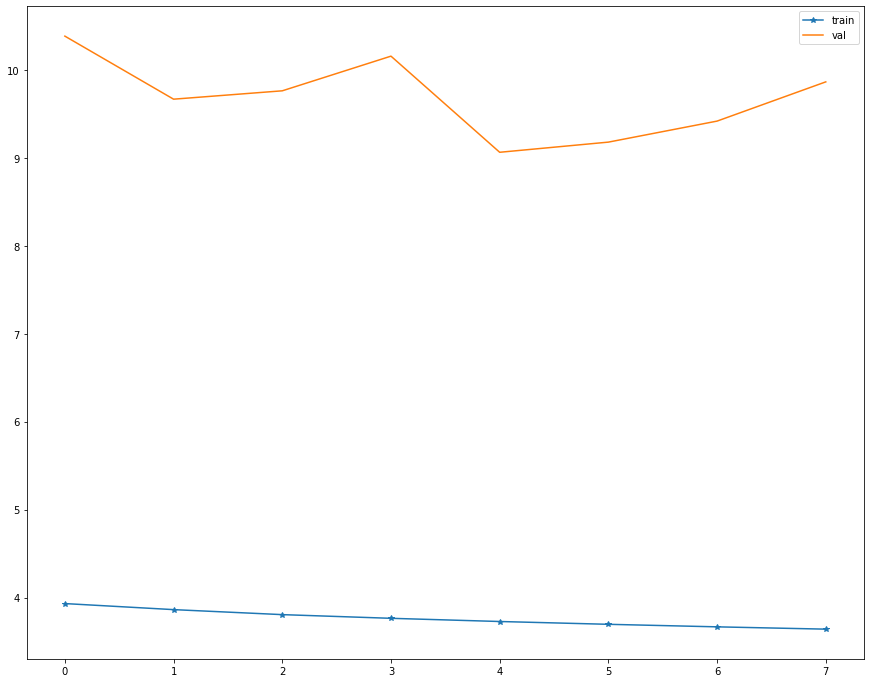

In [ ]:
# Learning curve
plt.plot(doc, '*-', label='train')
plt.plot(docval, label='val')
plt.legend()

In [ ]:
# ЧИСЛО ПАРАМЕТРОВ МОДЕЛИ 
sum(p.numel() for p in model.parameters() if p.requires_grad)

228428

### Отчет

Кратако укажите, что вы попробывали, что получилось и дало прирост, а что нет

Сколько параметров у модели?

Как быстро она предсказывает класс для 1й картинки?

Oпцианально: выведите top-1, top-5 точность вашей модели

Опцианально: выведите картинки, на которых ваша модель сильнее всего ошибается (вероятность класса, соответствующая таргету, минимальная)

In [ ]:
модель 1
TOP1 accuracy = 0.252
TOP5 accuracy = 0.497

модель 2
TOP1 accuracy = 0.290
TOP5 accuracy = 0.526

Когда закончите обучение, сделайте отдельно инференс на валидации и выведите ниже результат.

# Задача 2 - Transfer Learning (1 балл)

Выберите любую предобученную модель. Сделайте transfer learning для датасета из задачи 1. Постарайтесь по-максимуму воспользоваться кодом из задачи 1, чтобы не дублировать его. Выведите точность на валидации.

Help on package torchvision.models in torchvision:

NAME
    torchvision.models

PACKAGE CONTENTS
    _utils
    alexnet
    densenet
    detection (package)
    googlenet
    inception
    mnasnet
    mobilenet
    quantization (package)
    resnet
    segmentation (package)
    shufflenetv2
    squeezenet
    utils
    vgg
    video (package)

FILE
    /usr/local/lib/python3.6/dist-packages/torchvision/models/__init__.py




In [ ]:
resnet50 = torchvision.models.resnet50(pretrained=True)

In [ ]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# ПИШЕМ ЦИКЛ ОБУЧЕНИЯ
criterion = F.cross_entropy
optimizer = torch.optim.Adam(resnet50.parameters())


In [ ]:
doc = np.array([])
docval = np.array([])
early_stopping_rate = 1000
count = 0
for i in range(3):
  docs = train_one_epoch(resnet50, loaderGGGTrain, optimizer, device) # loader
  docs_ = val_one_epoch(resnet50, loaderGGGTest, device)
  doc = np.append(doc, docs)
  docval = np.append(docval, docs_)
  print("\n\tEpoch #%s" %i)
  print("\ttrain_loss =%.3f" %doc[-1], "val_loss =%.3f" %docval[-1], '\n')
  
  # Ранняя остановка
  if docval[-1] < early_stopping_rate:
    early_stopping_rate = docval[-1]
    count = 0
  else:
    count += 1
    if count == 3:
      break

  0%|          | 0/1562 [00:00<?, ?it/s]


	Epoch #0
	train_loss =3.196 val_loss =13.236 



  0%|          | 0/1562 [00:00<?, ?it/s]


	Epoch #1
	train_loss =2.768 val_loss =13.751 



100%|██████████| 156/156 [00:05<00:00, 26.77it/s]


	Epoch #2
	train_loss =2.617 val_loss =12.070 



# Задача 3 - Grouped Convolutions (2 балла)

Задача на понимание групповых сверток.

Стандартный вариант указать параметр __groups__  у `nn.Conv2d` и вызвать стандартный forward.

Попробуйте написать `forward` сами, воспользовавшись `torch.nn.functional.conv2d()` с одним ограничением, что параметр __groups__ в `torch.nn.functional.conv2d()` передавать нельзя.

Для решения советую циклом пройтись по `range(out_channels)` возможно с ненулевым шагом.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def custom_forward(conv, x):
    # put your code here
    return result

conv = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, groups=2, padding=1)
x = torch.rand(1, 8, 16, 16)
assert torch.allclose(conv(x), custom_forward(conv, x))

# Задача 4 - Self-supervised learning (много баллов)

Если вы дошли до задачи 4 и у вас еще много сил, энергии и времени, то вот вам настоящий challenge:

Прочитайте статью про FixMatch https://arxiv.org/abs/2001.07685

Вам предлагается в каком-либо виде воспользоваться предлагаемым в статье новым loss-ом применимо к задаче 1. А именно: в статье предлагается вариант того, как эффективно воспользоваться неразмеченными данными для улучшения качества модели.
Если у вас написан хороший код для задачи 1, то не должно вызвать больших трудностей добавить упомянутый подход.
Смотреть / использовать готовые какие-то реализации разрешается, главное вы должны понимать код, которым воспользовались.

Пара советов:
* скорей всего в одной из лекций мы покроем как писать свой вариант кастомный класс для загрузки данных, но вы можете сейчас попробовать погуглить (pytorch custom dataset) - он вам скорей всего понадобится, чтобы грузить одновременно размеченные и неразмеченные данные в 1 батче
* неразмеченные данные можно взять из любого другого датасета, например cifar-100 либо же для начала можно просто имеющиеся train данные поделить на две части и забыть про существование таргетов на одной из частей
* воспользуйтесь той же самой моделью и теми же самыми параметрами оптимизатора и т.д какие вы выбрали в 1й задаче
* сильные и слабые аугментации (см. статью) можете сделать внутри вашего кастомного класса с датасетом (т.е. агументировать данные до отправки на gpu) либо делать их уже после загрузки батча из dataloader (желательно на гпу). Во втором варианте советую воспользоваться https://kornia.readthedocs.io/en/latest/augmentation.html
* аугментации можете для дз сделать любые свои в качестве слабых и сильных, но на будущее старайтесь реимплемнтировать разные походы из статей как можно более похожим образом для начала, если еще нет интуиции как поменять что-то под вашу задачу, чтобы в случае если вы встраивате метод в какой-то пайплайн и у вас в итоге плохое качество, знать что в этом месте например проблемы нет, значит надо искать в другом месте